# First case with SHARPy
This notebook explains how to create a simple wing in SHARPy.

It aims to provide a big picture about the simulations in SHARPy describing the very fundamental concepts. 

This notebook requires around an hour to be completed.

## Generation of the case
This section explains how to generate the input files for SHARPy including the structure, the aerodynamics and the simulation details.

In [1]:
# Loading of the used packages
import numpy as np              # basic mathematical and array functions
import os                       # Functions related to the operating system
import matplotlib.pyplot as plt # Plotting library

import sharpy.sharpy_main                  # Run SHARPy inside jupyter notebooks
import sharpy.utils.plotutils as pu        # Plotting utilities
from sharpy.utils.constants import deg2rad # Constant to conver degrees to radians

import sharpy.utils.generate_cases as gc

The [generate cases](https://ic-sharpy.readthedocs.io/en/master/includes/utils/generate_cases/index.html) module of SHARPy tries to facilitate the creation of simple cases using common parameters as inputs and hidding the tedious work.

The following cells configures the plotting library to show the next graphics, it is not part of SHARPy.

In [2]:
from IPython.display import IFrame

### Define the case parameters
In this section, we define the basic parameters to create the simple wing case shown in the image below. SHARPy uses SI units for its variables unless stated otherwise.

In [3]:
%config InlineBackend.figure_format = 'svg'
from IPython.display import Image
url = ('https://raw.githubusercontent.com/ImperialCollegeLondon/sharpy/dev_example/docs/' + 
       'source/content/example_notebooks/images/simple_wing_scheme.png')
Image(url=url, width=800)

In [4]:
# Geometry
chord = 1.         # Chord of the airfoil
aspect_ratio = 16. # Ratio between lenght and chord: aspect_ratio = length/chord
wake_length = 50   # Length of the wake in chord lengths

# Discretization
num_node = 21           # Number of nodes in the structural discretisation
                        # The number of nodes will also define the aerodynamic panels in the 
                        # spanwise direction
num_chord_panels = 4    # Number of aerodynamic panels in the chordwise direction
num_points_camber = 200 # Number of points that will define the camber line of the airfoil

# Structural properties of the beam cross section
mass_per_unit_length = 0.75 # Mass per unit length
mass_iner_x = 0.1           # Mass inertia around the local x axis
mass_iner_y = 0.05          # Mass inertia around the local y axis
mass_iner_z = 0.05          # Mass inertia around the local z axis
pos_cg_B = np.zeros((3))    # position of the centre of mass with respect to the elastic axis
EA = 1e7                    # Axial stiffness
GAy = 1e6                   # Shear stiffness in the local y axis
GAz = 1e6                   # Shear stiffness in the local z axis
GJ = 1e4                    # Torsional stiffness
EIy = 2e4                   # Bending stiffness around the flapwise direction
EIz = 5e6                   # Bending stiffness around the edgewise direction

# Operation
WSP = 2.                # Wind speed 
air_density = 0.1       # Air density 

aoa_ini_deg = 2.        # Angle of attack at the beginning of the simulation 
aoa_end_deg = 1.        # Angle of attack at the end of the simulation 

# Time discretization
end_time = 5.0                  # End time of the simulation
dt = chord/num_chord_panels/WSP # Always keep one timestep per panel

In principle, we want to keep the size of the panels equal to the distance covered by the flow in one time step. 

### Structure

The section creates a class called ``AeroelasticInformation``. This class is not directly used by SHARPy, it has been thought as an intermediate step between common engineering inputs and the input information that SHARPy needs. 

It has a lot of functionalities (rotate objects, assembly simple strucures together ...) which can be looked up in the [documentation](https://ic-sharpy.readthedocs.io/en/master/includes/utils/generate_cases/index.html).

Let's initialise an Aeroelastic system that will include a ``StructuralInformation`` class and an ``AerodynamicInformation`` class:

In [5]:
airfoil = gc.AeroelasticInformation()

The attibutes that have to be defined (not all of them are compulsory) can be displayed with the code below. They constitute the input parameters to SHARPy and their names are intuitive, however, a complete description of the input variables to SHARPy can be found in the documentation: 
[structural inputs](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html#fem-file) and [aerodynamic inputs](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html#aerodynamics-file)

For example, the structural properties are:

In [6]:
airfoil.StructuralInformation.__dict__.keys()

dict_keys(['num_node_elem', 'num_node', 'num_elem', 'coordinates', 'connectivities', 'elem_stiffness', 'stiffness_db', 'elem_mass', 'mass_db', 'frame_of_reference_delta', 'structural_twist', 'boundary_conditions', 'beam_number', 'body_number', 'app_forces', 'lumped_mass_nodes', 'lumped_mass', 'lumped_mass_inertia', 'lumped_mass_position'])

For example, the connectivities between the nodes required by the finite element solver are empty so far:

In [7]:
print(airfoil.StructuralInformation.connectivities)

None


We can also list the methods that allow us to modify the structure. Check the [documentation ](https://ic-sharpy.readthedocs.io/en/master/includes/utils/generate_cases/index.html) for further information:

In [8]:
list_of_methdos = gc.list_methods(airfoil.StructuralInformation)

assembly_structures
check_StructuralInformation
compute_basic_num_elem
compute_basic_num_node
copy
create_frame_of_reference_delta
create_mass_db_from_vector
create_simple_connectivities
create_stiff_db_from_vector
generate_1to1_from_vectors
generate_fem_file
generate_full_structure
generate_uniform_beam
generate_uniform_sym_beam
rotate_around_origin
set_to_zero


First, we need to define the basic characteristics of the equations as the number of nodes, the number of nodes per element, the number of elements and the location of the nodes in the space:

In [9]:
# Define the number of nodes and the number of nodes per element
airfoil.StructuralInformation.num_node = num_node
airfoil.StructuralInformation.num_node_elem = 3
# Compute the number of elements assuming basic connections
airfoil.StructuralInformation.compute_basic_num_elem()

In [10]:
# Generate an array with the location of the nodes
node_r = np.zeros((num_node, 3))
node_r[:,1] = np.linspace(0, chord*aspect_ratio, num_node)
print(node_r)

[[ 0.   0.   0. ]
 [ 0.   0.8  0. ]
 [ 0.   1.6  0. ]
 [ 0.   2.4  0. ]
 [ 0.   3.2  0. ]
 [ 0.   4.   0. ]
 [ 0.   4.8  0. ]
 [ 0.   5.6  0. ]
 [ 0.   6.4  0. ]
 [ 0.   7.2  0. ]
 [ 0.   8.   0. ]
 [ 0.   8.8  0. ]
 [ 0.   9.6  0. ]
 [ 0.  10.4  0. ]
 [ 0.  11.2  0. ]
 [ 0.  12.   0. ]
 [ 0.  12.8  0. ]
 [ 0.  13.6  0. ]
 [ 0.  14.4  0. ]
 [ 0.  15.2  0. ]
 [ 0.  16.   0. ]]


The following function creates a unifrom beam from the previous parameters. On top of assigning the previous parameters, it defines other variables such as the connectivities between nodes

In [11]:
airfoil.StructuralInformation.generate_uniform_beam(node_r,
                    mass_per_unit_length,
                    mass_iner_x,
                    mass_iner_y,
                    mass_iner_z,
                    pos_cg_B,
                    EA,
                    GAy,
                    GAz,
                    GJ,
                    EIy,
                    EIz,
                    num_node_elem = airfoil.StructuralInformation.num_node_elem,
                    y_BFoR = 'x_AFoR',
                    num_lumped_mass=0)

If we now show the connectivities between nodes, the function has created them for us. [Further information](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html?highlight=connectivities#fem-file)

In [12]:
print(airfoil.StructuralInformation.connectivities)

[[ 0  2  1]
 [ 2  4  3]
 [ 4  6  5]
 [ 6  8  7]
 [ 8 10  9]
 [10 12 11]
 [12 14 13]
 [14 16 15]
 [16 18 17]
 [18 20 19]]


Let's define the boundary conditions as clamped for node 0 and free for the last node (-1) [Further information](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html?highlight=boundary#fem-file)

In [13]:
airfoil.StructuralInformation.boundary_conditions[0] = 1
airfoil.StructuralInformation.boundary_conditions[-1] = -1

### Aerodynamics
Appart from the structural properties defined above, we need to define the number of panels in the wake (``wake_panels``) and the camber line of the airfoil which, in this case, is flat. [Further information](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html#aerodynamics-file)

In [14]:
# Compute the number of panels in the wake (streamwise direction) based on the previous paramete
wake_panels = int(wake_length*chord/dt)

# Define the coordinates of the camber line of the airfoils used
airfoil_camber = np.zeros((1, num_points_camber, 2))
airfoil_camber[0, :, 0] = np.linspace(0, 1, num_points_camber)

The following function creates an aerodynamic surface uniform on top of the beam that we have already created

In [15]:
# Generate blade aerodynamics
airfoil.AerodynamicInformation.create_one_uniform_aerodynamics(airfoil.StructuralInformation,
                                 chord = chord,
                                 twist = 0.,
                                 sweep = 0.,
                                 num_chord_panels = num_chord_panels,
                                 m_distribution = 'uniform',
                                 elastic_axis = 0.5,
                                 num_points_camber = num_points_camber,
                                 airfoil = airfoil_camber)

### Summary
Now, we have all the inputs that we need for SHARPy. In this section, a first simulation with SHARPy is run. However, it will perform no computation, it will just load the data so we can plot the system we have just created.

SHARPy runs a series of [solvers](https://ic-sharpy.readthedocs.io/en/master/content/solvers.html) and [postprocessors](https://ic-sharpy.readthedocs.io/en/master/content/postproc.html) in the order indicated by the ``flow`` variable in the ``SHARPy`` dictionary.

The ``generate cases`` module also allows us to show all the avaiable solvers and all the parameters they accept as inputs. To do so, we need to run the following commands:

In [16]:
# Gather data about available solvers
SimInfo = gc.SimulationInformation() # Initialises the SimulationInformation class
SimInfo.set_default_values()         # Assigns the default values to all the solvers

# Print the available solvers and postprocessors
for key in SimInfo.solvers.keys():
    print(key)

_BaseStructural
AerogridLoader
BeamLoader
DynamicCoupled
DynamicUVLM
LinDynamicSim
LinearAssembler
Modal
NoAero
NonLinearDynamic
NonLinearDynamicCoupledStep
NonLinearDynamicMultibody
NonLinearDynamicPrescribedStep
NonLinearStatic
NonLinearStaticMultibody
PrescribedUvlm
RigidDynamicPrescribedStep
SHWUvlm
StaticCoupled
StaticCoupledRBM
StaticTrim
StaticUvlm
StepLinearUVLM
StepUvlm
Trim
LiftDistribution
Cleanup
AerogridPlot
BeamPlot
PlotFlowField
PickleData
FrequencyResponse
StallCheck
WriteVariablesTime
CreateSnapshot
AeroForcesCalculator
AsymptoticStability
BeamLoads
StabilityDerivatives
ShearVelocityField
DynamicControlSurface
GustVelocityField
TrajectoryGenerator
TurbVelocityField
SteadyVelocityField
StraightWake
HelicoidalWake
GridBox
BumpVelocityField
TurbVelocityFieldBts
SHARPy
SaveData


Let's output as an example, the input parameters of the ``BeamLoader`` solver. This solver is in charge of loading the structural infromation

In [17]:
SimInfo.solvers['BeamLoader']

{'unsteady': True, 'orientation': [1.0, 0, 0, 0]}

The following dictionary defines the basic inputs of SHARPy including the solvers to be run (``flow`` variable), the case name and the route in the file system. In this case we are turning off the screen output because it is useless because we are not running any computation. 

In [18]:
SimInfo.solvers['SHARPy']['flow'] = ['BeamLoader',
                        'AerogridLoader']

SimInfo.solvers['SHARPy']['case'] = 'plot'
SimInfo.solvers['SHARPy']['route'] = './'
SimInfo.solvers['SHARPy']['write_screen'] = 'off'

 We do not modify any of the default input paramteters in ``BeamLoader`` but we need to define the initial wake shape that we want and its size (``wake_panels``)

In [19]:
SimInfo.solvers['AerogridLoader']['unsteady'] = 'on'
SimInfo.solvers['AerogridLoader']['mstar'] = wake_panels
SimInfo.solvers['AerogridLoader']['freestream_dir'] = np.array([1.,0.,0.])
SimInfo.solvers['AerogridLoader']['wake_shape_generator'] = 'StraightWake'
SimInfo.solvers['AerogridLoader']['wake_shape_generator_input'] = {'u_inf': WSP,
                                                                   'u_inf_direction' : np.array(
                                                                                         [np.cos(aoa_ini_deg*deg2rad),
                                                                                         0.,
                                                                                         np.sin(aoa_ini_deg*deg2rad)]),
                                                                   'dt': dt}

The follwoing functions write the input files needed by SHARPy

In [20]:
gc.clean_test_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
airfoil.generate_h5_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
SimInfo.generate_solver_file()

The following line of code runs SHARPy inside the jupyter notebook. It is equivalent to run in a terminal: ``sharpy plot.sharpy`` being "plot" the case name defined above

In [21]:
sharpy_output = sharpy.sharpy_main.main(['',
                                         SimInfo.solvers['SHARPy']['route'] +
                                         SimInfo.solvers['SHARPy']['case'] +
                                         '.sharpy'])

Let's plot the case we have created. The function below provides a quick way of generating an interactive plot but it is not suitable for large cases. Luckily SHARPy has other more complex plotting capabilities.

If you download the original [jupyter notebook](https://ic-sharpy.readthedocs.io/en/master/content/examples.html) and you change thee geometric parameters above and rerun the jupyter notebook you will see its impact on the geometry.

Only the first 6 wake panels are plotted for efficiency.

In [22]:
# fig = pu.plot_timestep(sharpy_output, tstep=-1, minus_mstar=(wake_panels - 6), plotly=True)

In [23]:
IFrame(src='https://ic-sharpy.readthedocs.io/en/dev_example/content/example_notebooks/images/simple_airfoil_plot.html', width=900, height=600)

## Static simulation
Next, we run a static simulation of the previous system. We have already defined the required inputs for ``BeamLoader`` and ``AerogridLoader`` but we need to define the static solvers. We are going to use a FSI solver (``StaticCoupled``) that will include a structural solver (``NonLinearStatic``) and an aerodynamic solver (``StaticUvlm``). 

We use most of the default values but we redefine some of them:
- We assign the air density to all the solvers that need it
- We turn off the gravity on the structural solver
- We use a horseshoe solution without roll up for the aerodynamics
- We define the velocity field against the airfoil
- We do not use load steps in the FSI solver

In the documentation you can fine further information about the [modular framework](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html#modular-framework) and about the [solvers](https://ic-sharpy.readthedocs.io/en/master/content/solvers.html) and their inputs. 

In [24]:
# Define the simulation
SimInfo.solvers['SHARPy']['flow'] = ['BeamLoader',
                        'AerogridLoader',
                        'StaticCoupled']

SimInfo.set_variable_all_dicts('rho', air_density)

SimInfo.solvers['SHARPy']['case'] = 'static'
SimInfo.solvers['SHARPy']['write_screen'] = 'on'

SimInfo.solvers['NonLinearStatic']['gravity_on'] = False

SimInfo.solvers['StaticUvlm']['horseshoe'] = True
SimInfo.solvers['StaticUvlm']['n_rollup'] = 0
SimInfo.solvers['StaticUvlm']['velocity_field_generator'] = 'SteadyVelocityField'
SimInfo.solvers['StaticUvlm']['velocity_field_input'] = {'u_inf' : WSP,
                                                         'u_inf_direction' : np.array(
                                                                                [np.cos(aoa_ini_deg*deg2rad),
                                                                                 0.,
                                                                                 np.sin(aoa_ini_deg*deg2rad)])}

SimInfo.solvers['StaticCoupled']['structural_solver'] = 'NonLinearStatic'
SimInfo.solvers['StaticCoupled']['structural_solver_settings'] = SimInfo.solvers['NonLinearStatic']
SimInfo.solvers['StaticCoupled']['aero_solver'] = 'StaticUvlm'
SimInfo.solvers['StaticCoupled']['aero_solver_settings'] = SimInfo.solvers['StaticUvlm']
SimInfo.solvers['StaticCoupled']['n_load_steps'] = 0

The following functions create the input files required by SHARPy. For further information check:
- [Configuration file](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html#solver-configuration-file)
- [FEM input file](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html#fem-file)
- [Aerodynamic input file](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html#aerodynamics-file)


In [25]:
gc.clean_test_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
SimInfo.generate_solver_file()
airfoil.generate_h5_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])

In [26]:
# Running SHARPy again inside jupyter
sharpy_output = sharpy.sharpy_main.main(['',
                                         SimInfo.solvers['SHARPy']['route'] +
                                         SimInfo.solvers['SHARPy']['case'] +
                                         '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/arturo/code/sharpy/docs/source/content/example_notebooks
SHARPy being run is in /home/arturo/code/sharpy
The branch being run is dev_example
The version and com

The next function will plot the static equilibirium solution for the airfoil

In [27]:
# fig = pu.plot_timestep(sharpy_output, tstep=-1, minus_mstar=(wake_panels-6), plotly=True)
IFrame(src='https://ic-sharpy.readthedocs.io/en/dev_example/content/example_notebooks/images/simple_airfoil_static.html', width=900, height=600)

## Dynamic simulation
Finally, we run a dynamic simulation after the previous static one. With that objective, we include a dynamic FSI solver (``DynamicCoupled``)  in the simulation 

In [28]:
SimInfo.solvers['SHARPy']['flow'] = ['BeamLoader',
                        'AerogridLoader',
                        'StaticCoupled',
                        'DynamicCoupled']

SimInfo.solvers['SHARPy']['route'] = './'
SimInfo.solvers['SHARPy']['case'] = 'dynamic'

We need information about the time step and the number of iterations

In [29]:
# Compute the number of time steps needed based on the previous parameters
time_steps = int(end_time/dt)

# Define the time step and the number of time steps in every solver that requires them as input
SimInfo.set_variable_all_dicts('dt', dt)
SimInfo.define_num_steps(time_steps)

We define the approximation we are going to use for the wake convection (``convection_scheme``), the velocity field and deactivate the gravity.

We are going to use a FSI solver (``DynamicCoupled``) that couples a structual solver (``NonLinearDynamicPrescribedStep``) and an aerodynamic solver (``StepUvlm``).

Moreover, the FSI solver runs a series of postprocessors after each time step. Specifically it will save a plot of the structure (``BeamPlot``) and of the aerodynamic surfaces (``AerogridPlot``).

In [30]:
SimInfo.solvers['StepUvlm']['convection_scheme'] = 2
SimInfo.solvers['StaticUvlm']['velocity_field_generator'] = 'SteadyVelocityField'
SimInfo.solvers['StepUvlm']['velocity_field_input'] = {'u_inf' : WSP,
                                                       'u_inf_direction' : np.array(
                                                                              [np.cos(aoa_end_deg*deg2rad),
                                                                               0.,
                                                                               np.sin(aoa_end_deg*deg2rad)])}

SimInfo.solvers['NonLinearDynamicPrescribedStep']['gravity_on'] = False

SimInfo.solvers['DynamicCoupled']['structural_solver'] = 'NonLinearDynamicPrescribedStep'
SimInfo.solvers['DynamicCoupled']['structural_solver_settings'] = SimInfo.solvers['NonLinearDynamicPrescribedStep']
SimInfo.solvers['DynamicCoupled']['aero_solver'] = 'StepUvlm'
SimInfo.solvers['DynamicCoupled']['aero_solver_settings'] = SimInfo.solvers['StepUvlm']
SimInfo.solvers['DynamicCoupled']['postprocessors'] = ['BeamPlot', 'AerogridPlot']
SimInfo.solvers['DynamicCoupled']['postprocessors_settings'] = {'BeamPlot': SimInfo.solvers['BeamPlot'],
                                                             'AerogridPlot': SimInfo.solvers['AerogridPlot']}


Finally we need to define the movement of the whole wing through its velocity and acceleration. In this case we want a clamped structure so we will set every thing to zero.

Moreover, se can define forces applied togheter with the aerodynamic ones. In this case they will be set to zero.

In [31]:
SimInfo.with_forced_vel = True
SimInfo.for_vel = np.zeros((time_steps,6), dtype=float)
SimInfo.for_acc = np.zeros((time_steps,6), dtype=float)
SimInfo.with_dynamic_forces = True
SimInfo.dynamic_forces = np.zeros((time_steps,airfoil.StructuralInformation.num_node,6),
                                  dtype=float)

We write the input files required by SHARPy again:

In [32]:
gc.clean_test_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
airfoil.generate_h5_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
SimInfo.generate_solver_file()
SimInfo.generate_dyn_file(time_steps)

And we run the simulation

In [33]:
sharpy_output = sharpy.sharpy_main.main(['',
                                         SimInfo.solvers['SHARPy']['route'] +
                                         SimInfo.solvers['SHARPy']['case'] +
                                         '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/arturo/code/sharpy/docs/source/content/example_notebooks
SHARPy being run is in /home/arturo/code/sharpy
The branch being run is dev_example
The version and com

|  40   | 5.0000 |  3   |   0.320445   |   1.620201   |  -6.297170   | 0.000000e+00 | 0.000000e+00 |
...Finished
FINISHED - Elapsed time = 76.1527856 seconds
FINISHED - CPU process time = 337.2140226 seconds


This is the plot of the wing at the end of the simulation

In [34]:
# fig = pu.plot_timestep(sharpy_output, tstep=-1, minus_mstar=(wake_panels-6), plotly=True)
IFrame(src='https://ic-sharpy.readthedocs.io/en/dev_example/content/example_notebooks/images/simple_airfoil_dynamic.html', width=900, height=600)

## Postprocessing
As an example, we are going to plot the evolution of the tip position along time

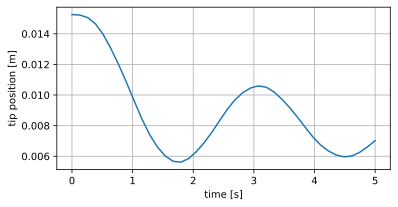

In [35]:
time = np.linspace(0, dt*time_steps, time_steps)
tip_pos = np.zeros((time_steps))
for it in range(time_steps):
    tip_pos[it] = sharpy_output.structure.timestep_info[it].pos[-1, 2]

fig, plots = plt.subplots(1, 1, figsize=(6, 3))

plots.grid()
plots.set_xlabel("time [s]")
plots.set_ylabel("tip position [m]")
plots.plot(time, tip_pos, '-')

plt.show()

## Conclusions
This notebook provides the big picture of the simulations with SHARPy. We recommend to go through the [documentation](https://ic-sharpy.readthedocs.io/en/master/) with special attention to the [SHARPy file description](https://ic-sharpy.readthedocs.io/en/master/content/casefiles.html) and the [examples](https://ic-sharpy.readthedocs.io/en/master/content/examples.html).